# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [ ]:
#load data
medv = pd.read_csv('/content/boston.csv')
medv.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9


The data is about predicting housing price (medv) in
Boston city, features:
*   Criminal rate (crim)
*   Residential land zoned proportion (zn)
*   Non-retail business acres proportion (indus)
*   Is bounds with river (chas)
*   Nitrogen oxides concentration (nox)
*   Number rooms average (rm)
*   Owner age proportion (age)
*   Weighted distance to cities (dis)
*   Accessibility index (rad)
*   Tax rate (tax)
*   Pupil-teacher ratio (ptratio)
*   Black proportion (black)
*   Percent lower status (lstat)

# Split Data: Train-Validation-Test

In [ ]:
#split train test
from sklearn.model_selection import train_test_split

feature = medv.drop(columns='medv')
target = medv[['medv']]

#first_splitting: pretrain and test
feature_medv_pretrain, feature_medv_test, target_medv_pretrain, target_medv_test = train_test_split(feature, target, test_size=0.20, random_state=42)

#second splitting: train and validation
feature_medv_train, feature_medv_validation, target_medv_train, target_medv_validation = train_test_split(feature_medv_pretrain, target_medv_pretrain, test_size=0.20, random_state=42)

# Multicollinearity Check

In [ ]:
#calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(feature_medv_train)

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])],index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


There are several features with high VIF scores:
*   Nox
*   Dis
*   Rad
*   Tax

Nox, dis, rad, and tax have vif values ​​above 4 while indus, age, and lstat have vif values above 3 (relatively high).

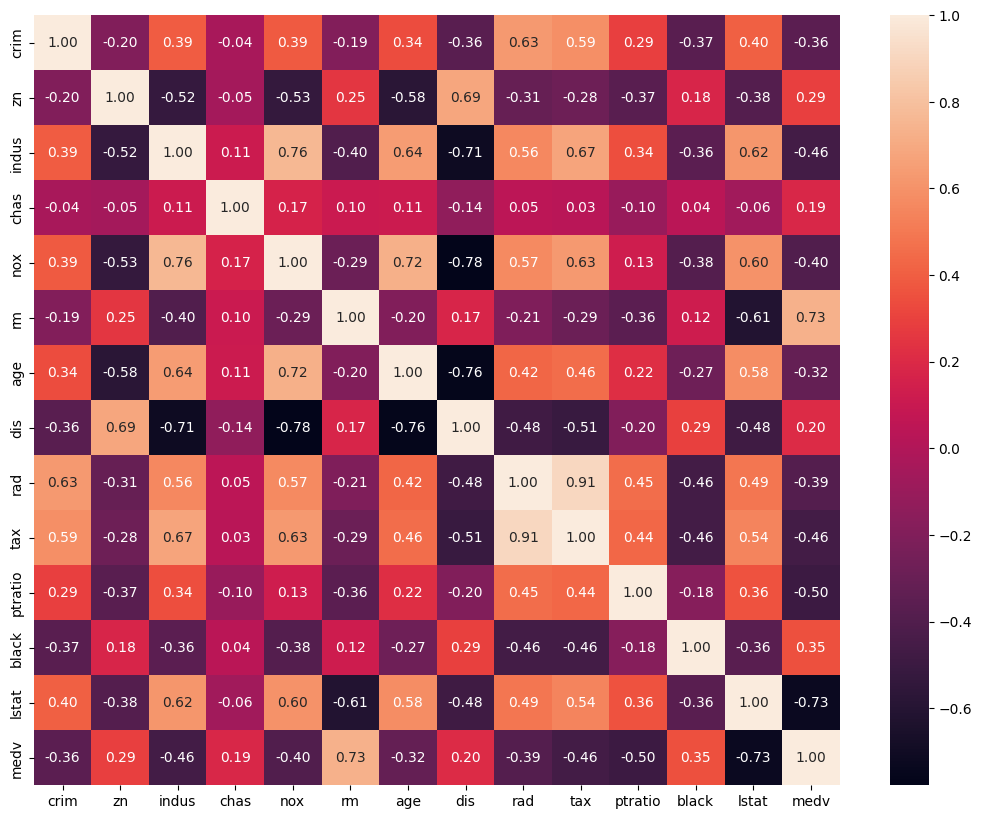

In [ ]:
#heatmap correlation
medv_train = pd.concat([feature_medv_train, target_medv_train], axis=1)
corr = medv_train.corr()

plt.figure(figsize=(13,10))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Multicollinearity:
* Tax has a high correlation with rad (0.91), nox also has a quite high correlation with tax (0.78), I decided to drop these 4 features (tax, rad, nox, and dis).
* Indus has a fairly high correlation with age (0.64) & with lstat (0.62). It also has relatively high vif value (3.7), among these three variables (indus, age, and lstat) lstat has a high correlation with medv (0.73). So, I decided to keep the lstat feature and remove the indus and age features.


Promising features:
*   lstat and rm have promising potential to be used as features because the correlation is quite high among other features (0.73).


# Drop Multicollinear Feature

In [ ]:
feature_medv_train = feature_medv_train.drop(columns=['tax','rad','nox','dis','indus','age'])
feature_medv_validation = feature_medv_validation.drop(columns=['tax','rad','nox','dis','indus','age'])
feature_medv_test = feature_medv_test.drop(columns=['tax','rad','nox','dis','indus','age'])

# Fit Multiple Models on Training Data

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

#train the model
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

#define the model
#4 models with different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

#fit the model(training)
ridge_reg_pointzeroone.fit(X_medv_train,y_medv_train)
ridge_reg_pointone.fit(X_medv_train,y_medv_train)
ridge_reg_one.fit(X_medv_train,y_medv_train)
ridge_reg_ten.fit(X_medv_train,y_medv_train)

Ridge(alpha=10, random_state=42)

## Lasso

In [ ]:
from sklearn.linear_model import Lasso

#train the model
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

#define the model
#4 models with different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

#fit the model(training)
lasso_reg_pointzeroone.fit(X_medv_train,y_medv_train)
lasso_reg_pointone.fit(X_medv_train,y_medv_train)
lasso_reg_one.fit(X_medv_train,y_medv_train)
lasso_reg_ten.fit(X_medv_train,y_medv_train)

Lasso(alpha=10, random_state=42)

# Choose the best lambda from validation set

## Ridge Regression

In [ ]:
from sklearn.metrics import mean_squared_error

X_medv_validation = feature_medv_validation.to_numpy()
y_medv_validation = target_medv_validation.to_numpy()
y_medv_validation = y_medv_validation.reshape(len(y_medv_validation),)

alphas = [0.01, 0.1, 1, 10]
models = [ridge_reg_pointzeroone, ridge_reg_pointone, ridge_reg_one, ridge_reg_ten]

for model, alpha in zip(models, alphas):
  y_predict_validation = model.predict(X_medv_validation)
  rmse = np.sqrt(mean_squared_error(y_medv_validation, y_predict_validation))
  print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.072568142964353
RMSE of Ridge regression model with alpha = 0.1 is 5.071804258896328
RMSE of Ridge regression model with alpha = 1 is 5.064399359342003
RMSE of Ridge regression model with alpha = 10 is 5.006917419058389


Best lambda/alpha = 10

## Lasso

In [ ]:
from sklearn.metrics import mean_squared_error

X_medv_validation = feature_medv_validation.to_numpy()
y_medv_validation = target_medv_validation.to_numpy()
y_medv_validation = y_medv_validation.reshape(len(y_medv_validation),)

alphas = [0.01, 0.1, 1, 10]
models = [lasso_reg_pointzeroone, lasso_reg_pointone, lasso_reg_one, lasso_reg_ten]

for model, alpha in zip(models, alphas):
  y_predict_validation = model.predict(X_medv_validation)
  rmse = np.sqrt(mean_squared_error(y_medv_validation, y_predict_validation))
  print(f'RMSE of Lasso model with alpha = {alpha} is {rmse}')

RMSE of Lasso model with alpha = 0.01 is 5.068007147397786
RMSE of Lasso model with alpha = 0.1 is 5.038252672890048
RMSE of Lasso model with alpha = 1 is 4.884214793644861
RMSE of Lasso model with alpha = 10 is 5.436607276239636


Best lambda/alpha = 1

# Coefficients

## Ridge Regression

In [ ]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,7.738509
1,crim,-0.044426
2,zn,-0.021479
3,chas,2.279306
4,rm,5.187088
5,ptratio,-0.867930
6,black,0.012693
7,lstat,-0.487948


Interpret:
*   7.738509: When other features (crim, zn, chas, rm, ptratio, black, & lstat are 0, the expected medv/housing price is 7.738509.
*   -0.044426: an increase of 1 on crim (criminal rate) is associated with a decrease of 0.044426 on medv/housing price.
*   -0.021479: an increase of 1 on zn (residential land zoned proportion) is associated with a decrease of 0.021479 on medv/housing price.
*   2.279306: an increase of 1 on chas (is bounds with river) is associated with an increase of 2.279306 on medv/housing price.
*   5.187088: an increase of 1 on rm (number rooms average) is associated with an increase of 5.187088 on medv/housing price.
*   -0.867930: an increase of 1 on ptratio (pupil-teacher ratio) is associated with a decrease of 0.867930 on medv/housing price.
*   0.012693: an increase of 1 on black (black proportion) is associated with an increase of 0.012693 on medv/housing price.
*   -0.487948: an increase of 1 on lstat (percent lower status) is associated with a decrease of 0.487948 on medv/housing price.









## Lasso

In [ ]:
lasso_best = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,22.934878
1,crim,-0.028582
2,zn,-0.015390
3,chas,0.000000
4,rm,2.940897
5,ptratio,-0.805332
6,black,0.011652
7,lstat,-0.626973


Interpret:
*    When other features (crim, zn, chas, rm, ptratio, black, & lstat are 0, the expected medv/housing price is 22.934878.
*   -0.028582: an increase of 1 on crim (criminal rate) is associated with a decrease of 0.028582 on medv/housing price.
*   -0.015390: an increase of 1 on zn (residential land zoned proportion) is associated with a decrease of 0.015390 on medv/housing price.
*   0.000000: chas (is bounds with river) feature dropped.
*   2.940897: an increase of 1 on rm (number rooms average) is associated with an increase of 2.940897 on medv/housing price.
*   -0.805332: an increase of 1 on ptratio (pupil-teacher ratio) is associated with a decrease of 0.805332 on medv/housing price.
*   0.011652: an increase of 1 on black (black proportion) is associated with an increase of 0.011652 on medv/housing price.
*   -0.626973: an increase of 1 on lstat (percent lower status) is associated with a decrease of 0.626973 on medv/housing price.



# Diagnostic Study

In [ ]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_medv_train)
print('R-squared for lasso model training data is {}'.format(r2_score(y_medv_train, y_predict_train)))

R-squared for lasso model training data is 0.6900473867450316


Interpret: 69,004% of variability of medv (housing price) is successfully explained using all the features in the lasso model.

In [ ]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_medv_train)
print('R-squared for ridge regression model training data is {}'.format(r2_score(y_medv_train, y_predict_train)))

R-squared for ridge regression model training data is 0.7265476554681276


Interpret: 72,654% of variability of medv (housing price) is successfully explained using all the features in the ridge regression model.

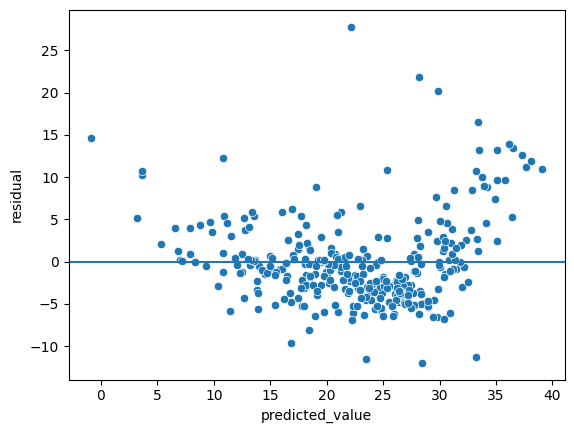

In [ ]:
# calculate residuals
residual = y_medv_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

# Training Error

## Ridge Regression

In [ ]:
#prepare prediction result on training data
y_predict_train = ridge_best.predict(X_medv_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RSME for training data is {}'.format(np.sqrt(mean_squared_error(y_medv_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_medv_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_medv_train, y_predict_train)))

RSME for training data is 4.983698513420199
MAE for training data is 3.523695602049664
MAPE for training data is 0.1735354346417717


Interpret:
*   The standard deviation of prediction errors is 4.938. From the regression line, the residuals mostly deviate between +- 4.938
*   On average, the prediction deviates the true medv (housing price) by 3.523.
*   Moreover, this 3.523 is equivalent to 17.353% deviation relative to the true medv (housing price).

## Lasso

In [ ]:
#prepare prediction result on training data
y_predict_train = lasso_best.predict(X_medv_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_medv_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_medv_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_medv_train, y_predict_train)))

RMSE for training data is 5.305894220058071
MAE for training data is 3.7816454630330565
MAPE for training data is 0.17631122802573085


Interpret:
*   The standard deviation of prediction errors is 5.305. From the regression line, the residuals mostly deviate between +- 5.305
*   On average, the prediction deviates the true medv (housing price) by 3.781.
*   Moreover, this 3.781 is equivalent to 17.631% deviation relative to the true medv (housing price).

# Testing Error

## Ridge Regression

In [ ]:
#prepare prediction result on test data
X_medv_test = feature_medv_test.to_numpy()
y_predict_test = ridge_best.predict(X_medv_test)

#ground truth target
y_medv_test = target_medv_test.to_numpy()
y_medv_test = y_medv_test.reshape(len(y_medv_test),)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_medv_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_medv_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_medv_test, y_predict_test)))

RMSE for testing data is 5.461480798628174
MAE for testing data is 3.3839971494852645
MAPE for testing data is 0.1801516203755049


Interpret:
*   The standard deviation of prediction errors is 5.461. From the regression line, the residuals mostly deviate between +- 5.461
*   On average, the prediction deviates the true medv (housing price) by 3.383.
*   Moreover, this 3.383 is equivalent to 18.015% deviation relative to the true medv (housing price).





Conclusion (Underfit? Overfit? or Acceptable?) on Ridge Regression Model:
*   Training error: 17.353%
*   Testing error: 18.015%

The model performance is quite good (17-18% error) but not the best. Also, the difference between training and testing error is 0.662%, which is small, so in conclusion the model is moderately acceptable.

## Lasso

In [ ]:
#prepare prediction result on test data
X_medv_test = feature_medv_test.to_numpy()
y_predict_test = lasso_best.predict(X_medv_test)

#ground truth target
y_medv_test = target_medv_test.to_numpy()
y_medv_test = y_medv_test.reshape(len(y_medv_test),)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_medv_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_medv_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_medv_test, y_predict_test)))

RMSE for testing data is 5.339076232426441
MAE for testing data is 3.5719427221707436
MAPE for testing data is 0.18387953211040675


Interpret:
*   The standard deviation of prediction errors is 5.339. From the regression line, the residuals mostly deviate between +- 5.339
*   On average, the prediction deviates the true medv (housing price) by 3.571.
*   Moreover, this 3.571 is equivalent to 18.387% deviation relative to the true medv (housing price).



Conclusion (Underfit? Overfit? or Acceptable?) on Lasso Model:
*   Training error: 17.631%
*   Testing error: 18.387%

The model performance is quite good (17-18% error) but not the best. Also, the difference between training and testing error is 0.765%, which is small, so in conclusion the model is moderately acceptable.

